# Étude de Cas - France

Dans ce notebook nous allons essayer de découvrire les variables qui influence sur l'apparition d'inondation en France

## Étape 1 : Données de précipitation

Dans un premier temps nous n'avons que les précipitations moyennes par mois ce qui n'est pas très représentatitif. En effet, les inondations sont plus du à des précipitations intenses.
Mais basons nous sur les données "../../datasets/precipitation"

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
DATASET_FOLDER = '../../datasets/'

In [6]:
past_time_series = ["1901-1930", "1931-1960", "1961-1990", "1901-2016", "1991-2016"]
futu_time_series = ["2020_2039", "2040_2059", "2060_2079", "2080_2099"]

df_pre = pd.DataFrame()

for period in past_time_series:
    df_temp = pd.read_csv(f'{DATASET_FOLDER}/precipitation/historical_{period}_FRA_France.csv')
    df_pre = df_pre.append(df_temp)
df_pre.head()

,Rainfall - (MM),Year,Statistics,Country,ISO3
0,40.9290,1901,Jan Average,France,FRA
1,34.7865,1901,Feb Average,France,FRA
2,90.9714,1901,Mar Average,France,FRA
3,83.1600,1901,Apr Average,France,FRA
4,42.6287,1901,May Average,France,FRA


# Étape 2 : Données de désastre

Nous allons comparer les données des désastres à celle des précipitations

In [7]:
df_des = pd.read_excel('../../datasets/emdat_public_2020_09_12_query_uid-tAnKEX.xlsx', index_col=0)

# Mise en forme de la dataframe (les premières lignes ne nous interessent pas)
df_des.columns = list(df_des.iloc[5])
df_des = df_des.iloc[6:]

# On ne prends que les désatres de type inondations
df_des = df_des[df_des['Disaster Type'] == 'Flood']

Dans notre cas on va utiliser que les données sur la France.
Et comme on a que les mois de précipitations on ne va garder que cela.

In [8]:
df_des_fr = df_des[df_des['Country'] == 'France'][['Year', 'Start Month']]

In [9]:
df_des_fr.head()

,Year,Start Month
Source:,,
1958-0039-FRA,1958,9
1977-0084-FRA,1977,7
1978-0010-FRA,1978,1
1980-0237-FRA,1980,9
1981-0217-FRA,1981,12


## Étape 3 : Croiser les données

On va maintenant croiser les deux bases de données et appliquer des outils statistques pour voir si la précipitation à un lien avec les désastres.
Pour cela on crée une variable communes : XX - XXXX (mois-année)

In [10]:
def abreviation2nombre(abr):
    lst_abr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return(lst_abr.index(abr)+1)

In [11]:
df_pre['Month'] = df_pre[' Statistics'].str[:4].apply(lambda x: abreviation2nombre(x.strip()))

df_pre['Date'] = df_pre[['Month',' Year']].apply(lambda x: f'{x[0]:0>2}-{x[1]}', axis=1)

In [12]:
df_pre

,Rainfall - (MM),Year,Statistics,Country,ISO3,Month,Date
0,40.9290,1901,Jan Average,France,FRA,1,01-1901
1,34.7865,1901,Feb Average,France,FRA,2,02-1901
2,90.9714,1901,Mar Average,France,FRA,3,03-1901
3,83.1600,1901,Apr Average,France,FRA,4,04-1901
4,42.6287,1901,May Average,France,FRA,5,05-1901
...,...,...,...,...,...,...,...
307,24.9382,2016,Aug Average,France,FRA,8,08-2016
308,39.8369,2016,Sep Average,France,FRA,9,09-2016
309,61.6580,2016,Oct Average,France,FRA,10,10-2016
310,95.7876,2016,Nov Average,France,FRA,11,11-2016


In [13]:
df_des_fr['Date'] = df_des_fr[['Start Month','Year']].apply(lambda x: f'{x[0]:0>2}-{x[1]}', axis=1)

df_pre['Désastre'] = df_pre['Date'].isin(list(df_des_fr['Date']))

## Étape 4 : Visualisation

Nous allons voir si on peut prédire une inondation avec la quantité de précipitation

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

import numpy as np

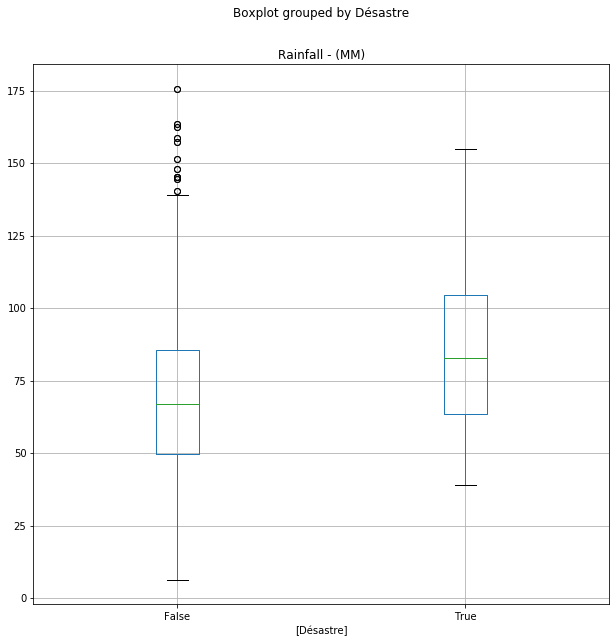

In [15]:
df_pre.boxplot(['Rainfall - (MM)'], by=['Désastre'], figsize=(10,10))
plt.show()

On voit donc qu'il y a bien un écart entre les précipitations lorsqu'il y a un désastre et lorsqu'il n'y en a pas. Mais il y a également de grandes zones de recoupage.

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
X = df_pre['Rainfall - (MM)'].values.reshape(-1,1)
Y = df_pre['Désastre'].values

In [18]:
# On découpe la base de donnée
X_train, X_test, y_train, y_test = train_test_split(X, Y,\
                                                    test_size=0.25,\
                                                    random_state=27)

In [19]:
# On peut commencer par une simple régréssion linéaire
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [20]:
accuracy_score(y_test, lr_pred)

0.9655172413793104

In [21]:
pd.DataFrame(confusion_matrix(y_test, lr_pred))

,0,1
0,672,0
1,24,0


Malheureusement, le nombre de désastres est très petit comparé au nombre total d'observations (ce qui est une bonne chose dans l'absolu :)).
Mais cela fait qu'on se retrouve ici avec un gros problème de prédiction, la régression linéaire a préféré mettre tous les possiblités à 'Pas désastre'. 
C'est donc pas suffisant pour éstimer les désastres nous allons donc incorporer le mois du désastre. D'après cet article : (https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18) les randoms forests sont plus adaptés pour les base de données déséquilibrées.

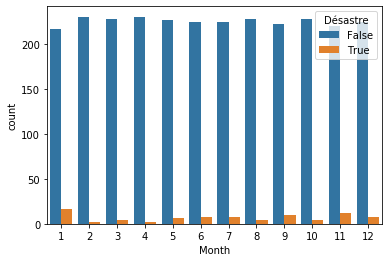

In [22]:
sns.countplot(df_pre['Month'], hue=df_pre['Désastre'])

In [23]:
X = df_pre[['Rainfall - (MM)', 'Month']].values.reshape(-1,1)

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

accuracy_score(y_test, rfc_pred)

0.985632183908046

In [24]:
pd.DataFrame(confusion_matrix(y_test, rfc_pred))

,0,1
0,670,2
1,8,16


In [25]:
recall_score(y_test, rfc_pred)

0.6666666666666666

On voit que la prédiction à bien mieux marché mais que le score 'recall' défini par le nombre de positif divisé par le nombre réel de positif et encore plutôt bas. Il faut donc concidérer d'autre facteur pour la prédiction.